In [1]:
import cv2, datetime, time, numpy, pygame, threading, math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
COLOR_LINE_FOLLOWING = True # False to use grayscale thresholds, true to use color thresholds.
COLOR_THRESHOLDS = [( 85, 100,  -40,  -10,    0,  127)] # Yellow Line.
GRAYSCALE_THRESHOLDS = [(240, 255)] # White Line.
COLOR_HIGH_LIGHT_THRESHOLDS = [(80, 100, -10, 10, -10, 10)]
# https://pythonprogramming.net/color-filter-python-opencv-tutorial/
COLOR_HIGH_LIGHT_THRESHOLDS_MAX = numpy.array([255,255,255])
COLOR_HIGH_LIGHT_THRESHOLDS_MIN = numpy.array([230,230,230])
#COLOR_HIGH_LIGHT_THRESHOLDS_MAX = numpy.array([255,190,50])
#COLOR_HIGH_LIGHT_THRESHOLDS_MIN = numpy.array([170,0,0])

#FRAME_EXPOSURE = 0.000001
FRAME_EXPOSURE = 0
GRAYSCALE_HIGH_LIGHT_THRESHOLDS = [(250, 255)]
BINARY_VIEW = False # Helps debugging but costs FPS if on.
#BINARY_VIEW = True # Helps debugging but costs FPS if on.
DO_NOTHING = False # Just capture frames...

#FRAME_SIZE = sensor.QQVGA # Frame size.
FRAME_WIDTH = 160
FRAME_HEIGHT = 120
FRAME_REGION = 0.75 # Percentage of the image from the bottom (0 - 1.0).
FRAME_WIDE = 1.0 # Percentage of the frame width.

# Set up the ROI

# Trapezoid
ROI_VERTICES = numpy.array([[0,119], [0,90], [70,20], [90,20], [159,90], [159,119]], dtype=numpy.int32)
ROI_MASK = numpy.zeros((120, 160), numpy.uint8)
cv2.fillConvexPoly(ROI_MASK, ROI_VERTICES, 255)

AREA_THRESHOLD = 0 # Raise to filter out false detections.
PIXELS_THRESHOLD = 40 # Raise to filter out false detections.
MAG_THRESHOLD = 4 # Raise to filter out false detections.
MIXING_RATE = 0.9 # Percentage of a new line detection to mix into current steering.

In [ ]:
frame1 = cv2.imread('camera01.jpg')
frame3 = cv2.imread('camera03.png')
test1 = cv2.imread('data/686_cam-image_array_.jpg')

print ("image size: {}".format(frame1.shape))
print ("image size: {}".format(frame3.shape))
print ("image size: {}".format(test1.shape))

In [ ]:
def demonstrate_HSV(frame):
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    f, axes = plt.subplots(2, 2, figsize=(20, 12))
    f.tight_layout()
    axes[0,0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axes[0,1].imshow(frame_hsv[:,:,0], cmap='gray')
    axes[1,0].imshow(frame_hsv[:,:,1], cmap='gray')
    axes[1,1].imshow(frame_hsv[:,:,2], cmap='gray')
    plt.show()

# Uncomment to run
#demonstrate_HSV(frame1)

In [ ]:
def demonstrate_HLS(frame):
    frame_hls = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS)

    f, axes = plt.subplots(2, 2, figsize=(20, 12))
    f.tight_layout()
    axes[0,0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axes[0,1].imshow(frame_hls[:,:,0], cmap='gray')
    axes[1,0].imshow(frame_hls[:,:,1], cmap='gray')
    axes[1,1].imshow(frame_hls[:,:,2], cmap='gray')
    plt.show()
    
# Uncomment to run
#demonstrate_HLS(frame1)

In [ ]:
def elapsed_note(label, prev=0):
    global g_prev_time
    
    now = datetime.datetime.now()
    if (prev != 0):
        delta_time = (now - prev).microseconds / 1000000
    else:
        delta_time = (now - g_prev_time).microseconds / 1000000
        g_prev_time = now
    
    print ("%6.6fs %s" % (delta_time, label))

In [ ]:
def original_line_finding(frame):
    global g_prev_time
    
    cur_time = datetime.datetime.now()
    g_prev_time = cur_time

    # Define a color mask between white and a light grey
    # COLOR_HIGH_LIGHT_THRESHOLDS_MAX = numpy.array([255,255,255])
    # COLOR_HIGH_LIGHT_THRESHOLDS_MIN = numpy.array([230,230,230])
    color_mask = cv2.inRange(frame, COLOR_HIGH_LIGHT_THRESHOLDS_MIN, COLOR_HIGH_LIGHT_THRESHOLDS_MAX)
    elapsed_note("Color mask")

    # Mask pixels with colors that aren't within range
    res = cv2.bitwise_and(frame, frame, mask=color_mask)
    elapsed_note("bitwise color_mask")

    # Mask pixels that aren't in our region of interest
    res = cv2.bitwise_and(res, res, mask=ROI_MASK)
    elapsed_note("bitwise ROI_MASK")

    # Convert the masked color image to grayscale (1 color channel)
    gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    elapsed_note("color -> gray")

    # Apply a blur to get rid of hard edges?
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    elapsed_note("gaussian blur")

    # Convert back from grayscale to color (still gray values but 3 color channels)
    res = cv2.cvtColor(blur, cv2.COLOR_GRAY2BGR)
    elapsed_note("gray -> color")

    if True:
        lines = None
        # Get an array of pixels that do not have values set to 0
        pixelpoints = cv2.findNonZero(blur)
        elapsed_note("findNonZero")
        if pixelpoints is not None:
            try:
                # Attempt to fit a line to the pixels
                # run, rise, points on line
                [vx,vy,x,y] = cv2.fitLine(pixelpoints, cv2.DIST_L2, 0, 0.01, 0.01)
                elapsed_note("fitLine: {} {} {} {}".format(vx, vy, x, y))
                line = [vx,vy,x,y]
            except:
                line = False
                pass
        else:
            line = False

    else:
        edges = cv2.Canny(blur, 50, 150)
        dilation = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)))
        res_gray = cv2.erode(dilation, cv2.getStructuringElement(cv2.MORPH_ERODE, (3, 3)))
        #res_gray = blur + erosion
        lines = cv2.HoughLinesP(res_gray, 2, numpy.pi/180, 20, numpy.array([]), minLineLength=30, maxLineGap=30)
        if lines is not None:
            line_img = numpy.zeros((res.shape[0], res.shape[1], 3), dtype=numpy.uint8)
            for line in lines:
                for x1,y1,x2,y2 in line:
                    angle = numpy.arctan2(y2 - y1, x2 - x1) * 180. / numpy.pi
                    if ( (abs(angle) > 20.) and (abs(angle) < 90.)):
                        cv2.line(line_img, (x1, y1), (x2, y2), (0,0,255), 1)
            res = cv2.cvtColor(res_gray, cv2.COLOR_GRAY2BGR)
            res = cv2.addWeighted(res, 0.8, line_img, 1, 0)
            gray_lines = cv2.cvtColor(line_img, cv2.COLOR_BGR2GRAY)
            pixelpoints = cv2.findNonZero(gray_lines)
            if pixelpoints is not None:
                try:
                    [vx,vy,x,y] = cv2.fitLine(pixelpoints, 4, 0, 0.01, 0.01)
                    line = [vx,vy,x,y]
                except:
                    line = False
                    pass
            else:
                line = False
        else:
            line = False

    elapsed_note("fitLine")

    print_string = ""
    if line:
        try:
            # y = mx + b
            lefty = int((-x*vy/vx) + y)
            righty = int(((160-x)*vy/vx)+y)
            res = cv2.line(res, (159,righty), (0,lefty), (0,255,0), 2)
        except:
            line = False
            pass

        elapsed_note("draw line")

    '''
    if line:
        new_time = datetime.datetime.now()
        delta_time = (new_time - old_time).microseconds / 1000
        old_time = new_time
    '''

    elapsed_note("TOTAL", cur_time)

    # print ("[vx, vy, x, y]: {}".format(line))

    f, axes = plt.subplots(2, 2, figsize=(20, 12))
    f.tight_layout()
    axes[0,0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axes[0,1].imshow(color_mask, cmap='gray')
    axes[1,0].imshow(ROI_MASK, cmap='gray')
    axes[1,1].imshow(res)
    plt.show()

# Uncomment to run
#original_line_finding(frame1)

In [ ]:
def updated_line_finding(frame, process='Default'):
    global g_prev_time
    
    cur_time = datetime.datetime.now()
    g_prev_time = cur_time

    # Convert to HSV
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    elapsed_note("Color convert to HSV")

    # Define a color mask between white and a light grey
    # COLOR_HIGH_LIGHT_THRESHOLDS_MAX = numpy.array([255,255,255])
    # COLOR_HIGH_LIGHT_THRESHOLDS_MIN = numpy.array([230,230,230])
    #color_mask = cv2.inRange(frame, COLOR_HIGH_LIGHT_THRESHOLDS_MIN, COLOR_HIGH_LIGHT_THRESHOLDS_MAX)

    if (process == 'Equalize'):
        # https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
        equ = cv2.equalizeHist(frame_hsv[:,:,2])
        elapsed_note("Equalized histogram. equ shape: {}".format(equ.shape))

        color_mask = cv2.inRange(equ, 230, 255)
        elapsed_note("Color mask. color_mask shape: {}".format(color_mask.shape))
    elif (process == 'Clahe'):
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        equ = clahe.apply(frame_hsv[:,:,2])
        elapsed_note("Equalized via Clahe. equ shape: {}".format(equ.shape))
        
        color_mask = cv2.inRange(equ, 170, 255)
        elapsed_note("Color mask. color_mask shape: {}".format(color_mask.shape))
    else:
        color_mask = cv2.inRange(frame_hsv[:,:,2], 180, 255)
        elapsed_note("Color mask. color_mask shape: {}".format(color_mask.shape))
    
    # Mask pixels with colors that aren't within range
    masked = cv2.bitwise_and(frame_hsv[:,:,2], frame_hsv[:,:,2], mask=color_mask)
    elapsed_note("bitwise color_mask. masked shape: {}".format(masked.shape))

    # Mask pixels that aren't in our region of interest
    masked = cv2.bitwise_and(masked, masked, mask=ROI_MASK)
    elapsed_note("bitwise ROI_MASK. masked shape: {}".format(masked.shape))

    # Convert the masked color image to grayscale (1 color channel)
    #gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
    #elapsed_note("color -> gray. gray shape: {}".format(gray.shape))

    # Apply a blur to get rid of hard edges?
    #blur = cv2.GaussianBlur(masked, (7, 7), 0)
    #elapsed_note("gaussian blur. blur shape: {}".format(blur.shape))

    # Convert back from grayscale to color (still gray values but 3 color channels)
    res = cv2.cvtColor(masked, cv2.COLOR_GRAY2BGR)
    elapsed_note("gray -> color. res shape: {}".format(res.shape))

    if True:
        lines = None
        # Get an array of pixels that do not have values set to 0
        pixelpoints = cv2.findNonZero(masked)
        elapsed_note("findNonZero")
        if pixelpoints is not None:
            try:
                # Attempt to fit a line to the pixels
                # run, rise, points on line
                [vx,vy,x,y] = cv2.fitLine(pixelpoints, cv2.DIST_L2, 0, 0.01, 0.01)
                elapsed_note("fitLine: {} {} {} {}".format(vx, vy, x, y))
                line = [vx,vy,x,y]
            except:
                line = False
                pass
        else:
            line = False

    else:
        edges = cv2.Canny(blur, 50, 150)
        dilation = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)))
        res_gray = cv2.erode(dilation, cv2.getStructuringElement(cv2.MORPH_ERODE, (3, 3)))
        #res_gray = blur + erosion
        lines = cv2.HoughLinesP(res_gray, 2, numpy.pi/180, 20, numpy.array([]), minLineLength=30, maxLineGap=30)
        if lines is not None:
            line_img = numpy.zeros((res.shape[0], res.shape[1], 3), dtype=numpy.uint8)
            for line in lines:
                for x1,y1,x2,y2 in line:
                    angle = numpy.arctan2(y2 - y1, x2 - x1) * 180. / numpy.pi
                    if ( (abs(angle) > 20.) and (abs(angle) < 90.)):
                        cv2.line(line_img, (x1, y1), (x2, y2), (0,0,255), 1)
            res = cv2.cvtColor(res_gray, cv2.COLOR_GRAY2BGR)
            res = cv2.addWeighted(res, 0.8, line_img, 1, 0)
            gray_lines = cv2.cvtColor(line_img, cv2.COLOR_BGR2GRAY)
            pixelpoints = cv2.findNonZero(gray_lines)
            if pixelpoints is not None:
                try:
                    [vx,vy,x,y] = cv2.fitLine(pixelpoints, 4, 0, 0.01, 0.01)
                    line = [vx,vy,x,y]
                except:
                    line = False
                    pass
            else:
                line = False
        else:
            line = False

    elapsed_note("fitLine")

    print_string = ""
    if line:
        try:
            # y = mx + b
            lefty = int((-x*vy/vx) + y)
            righty = int(((160-x)*vy/vx)+y)
            res = cv2.line(res, (159,righty), (0,lefty), (0,255,0), 2)
        except:
            line = False
            pass

        elapsed_note("draw line")

    '''
    if line:
        new_time = datetime.datetime.now()
        delta_time = (new_time - old_time).microseconds / 1000
        old_time = new_time
    '''

    elapsed_note("TOTAL", cur_time)

    # print ("[vx, vy, x, y]: {}".format(line))

    f, axes = plt.subplots(2, 2, figsize=(20, 12))
    f.tight_layout()
    axes[0,0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if (process != 'Default'):
        axes[0,1].imshow(equ, cmap='gray')
    else:
        axes[0,1].imshow(color_mask, cmap='gray')
    axes[1,0].imshow(ROI_MASK, cmap='gray')
    axes[1,1].imshow(res)
    plt.show()
    
# Uncomment to run
#updated_line_finding(frame1)

In [ ]:
updated_line_finding(frame3)

In [ ]:
updated_line_finding(test1, process='Default')

In [ ]:
for i in range(5):
    val = "%05d" % i
    print (val)

In [ ]:
import re
import glob

DATA_DIR = "data/data_20180724_01/"
PREFIX = "cam"

#DATA_DIR = "data/tub_8_18-03-31/"
#PREFIX = ""

def get_file_num(pathname):
    m = re.search("[^0-9]*(\d+)[^0-9]*\.(png|jpg)$", pathname)
    return int(m.group(1))

#get_file_num(DATA_DIR + PREFIX + "1020_cam-image_array_.png")
    
for filename in sorted(glob.glob(DATA_DIR + PREFIX + "*.png") + glob.glob(DATA_DIR + PREFIX + "*.jpg"), key=get_file_num):
    print ("{}".format(filename))


In [ ]:
# https://www.sthu.org/blog/13-perstopology-peakdetection/index.html

class Peak:
    def __init__(self, startidx):
        self.born = self.left = self.right = startidx
        self.died = None

    def get_persistence(self, seq):
        return float("inf") if self.died is None else seq[self.born] - seq[self.died]

def get_persistent_homology(seq):
    peaks = []
    # Maps indices to peaks
    idxtopeak = [None for s in seq]
    # Sequence indices sorted by values
    indices = range(len(seq))
    indices = sorted(indices, key = lambda i: seq[i], reverse=True)

    # Process each sample in descending order
    for idx in indices:
        lftdone = (idx > 0 and idxtopeak[idx-1] is not None)
        rgtdone = (idx < len(seq)-1 and idxtopeak[idx+1] is not None)
        il = idxtopeak[idx-1] if lftdone else None
        ir = idxtopeak[idx+1] if rgtdone else None

        # New peak born
        if not lftdone and not rgtdone:
            peaks.append(Peak(idx))
            idxtopeak[idx] = len(peaks)-1

        # Directly merge to next peak left
        if lftdone and not rgtdone:
            peaks[il].right += 1
            idxtopeak[idx] = il

        # Directly merge to next peak right
        if not lftdone and rgtdone:
            peaks[ir].left -= 1
            idxtopeak[idx] = ir

        # Merge left and right peaks
        if lftdone and rgtdone:
            # Left was born earlier: merge right to left
            if seq[peaks[il].born] > seq[peaks[ir].born]:
                peaks[ir].died = idx
                peaks[il].right = peaks[ir].right
                idxtopeak[peaks[il].right] = idxtopeak[idx] = il
            else:
                peaks[il].died = idx
                peaks[ir].left = peaks[il].left
                idxtopeak[peaks[ir].left] = idxtopeak[idx] = ir

    # This is optional convenience
    return sorted(peaks, key=lambda p: p.get_persistence(seq), reverse=True)

In [3]:
# http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

# %load ./../functions/detect_peaks.py
"""Detect peaks in data based on their amplitude and other features."""

from __future__ import division, print_function
import numpy as np

__author__ = "Marcos Duarte, https://github.com/demotu/BMC"
__version__ = "1.0.4"
__license__ = "MIT"


def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()

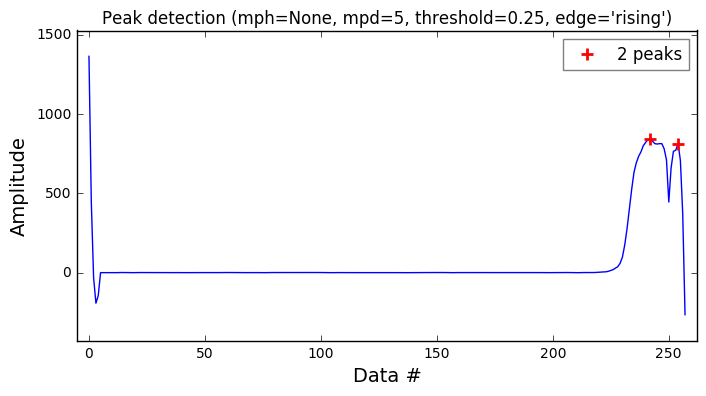

left_idx: 242 right_idx: 254


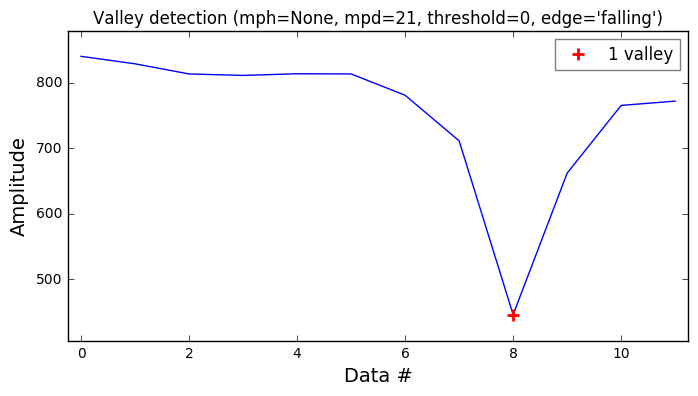

min_idx: -1 (adjusted: 241), min_val: 300
thresh: 241


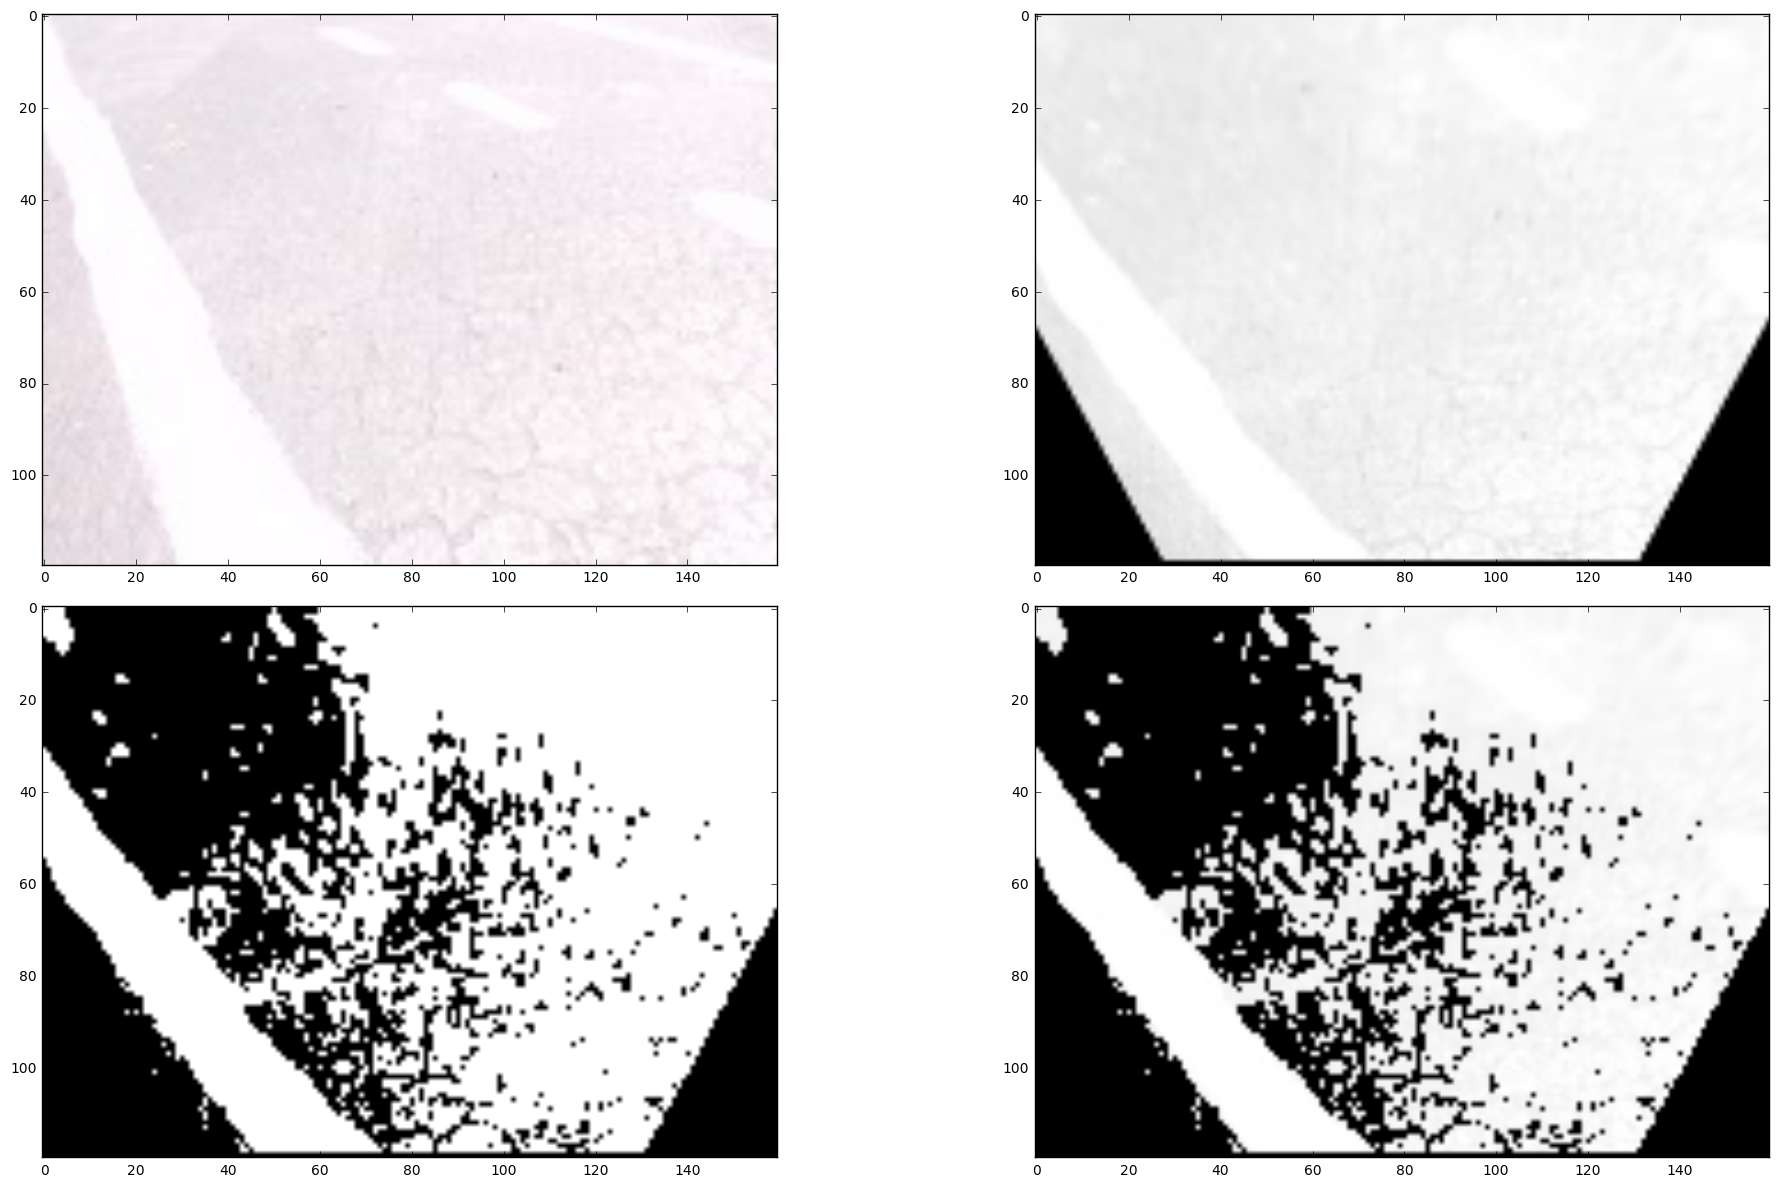

In [21]:
#import sys
#sys.path.insert(1, r'./../functions')  # add to pythonpath
#from detect_peaks import detect_peaks

from scipy.signal import savgol_filter
from BirdsEyeTransform import BirdsEyeTransform

def c2v(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,2]

def find_threshold(hist, show_plot=False):
    
    padded = numpy.append(hist, [1, 0, 0])

    smoothed = savgol_filter(padded, 9, 3)
    peaks = detect_peaks(smoothed, mpd=5, threshold=0.25, show=show_plot)
    
    right_idx = peaks[-1]
    left_max = -1
    left_idx = -1
    for p in peaks[:-1]:
        if smoothed[p] > left_max:
            left_max = smoothed[p]
            left_idx = p        
    
    print ("left_idx: {} right_idx: {}".format(left_idx, right_idx))
    
    if left_idx == -1:
        left_idx = 191 # put at 75%
        print ("left_idx not detected. setting to {}".format(left_idx))

    minimums = detect_peaks(smoothed[left_idx:right_idx], mpd=21, valley=True, edge='falling', show=show_plot)
    
    min_val = 300 # more than 255 max value
    min_idx = -1
    for p in minimums:
        if smoothed[left_idx + p] < min_val:
            min_val = smoothed[left_idx + p]
            min_idx = p

    print ("min_idx: {} (adjusted: {}), min_val: {}".format(min_idx, min_idx + left_idx, min_val))
    
    return left_idx + min_idx

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def show_histogram(img, thresh=240):
    bright = c2v(img)

    hist, bin_edges = numpy.histogram(bright, 128)

    #find_threshold(hist)
    
    #print (hist)
    plt.bar(bin_edges[:-1] / 4, hist)
    plt.axis('tight')
    plt.show()

    #ph = get_persistent_homology(hist)
    #for peak in ph:
    #    print ("{} -> {}".format(peak.born, peak.died))

    f, axes = plt.subplots(1, 2, figsize=(4, 3))
    f.tight_layout()
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[1].imshow(bright, cmap='gray')
    plt.show()

"""
SETUP
"""
test_images = []
#test_images.append(cv2.imread("data/data_20180724_02/cam00025.png"))
#test_images.append(cv2.imread("data/data_20180724_02/cam00022.png"))
#test_images.append(cv2.imread("data/data_20180724_02/cam00060.png"))
#test_images.append(cv2.imread("data/data_20180724_01/cam00755.png"))
test_images.append(cv2.imread("data/data_20180724_02/cam00756.png"))
#test_images.append(cv2.imread("data/data_20180724_02/cam00758.png"))

# Set up the birds eye transformation
t_y = int(0.2 * FRAME_HEIGHT)
b_y = int(1.0 * FRAME_HEIGHT)
tl_x = int(0.25 * FRAME_WIDTH)
tr_x = int(0.75 * FRAME_WIDTH)
bl_x = int(0.0 * FRAME_WIDTH)
br_x = int(1.0 * FRAME_WIDTH)

d_t_y = int(FRAME_HEIGHT * 0.2)
d_b_y = int(FRAME_HEIGHT - 1)
d_l_x = int(0.18 * FRAME_WIDTH)
d_r_x = int(0.82 * FRAME_WIDTH)

#                          TL             TR             BR             BL
trans_src = np.float32([(tl_x,t_y),    (tr_x,t_y),    (br_x,b_y),    (bl_x,b_y)])
trans_dst = np.float32([(d_l_x,d_t_y), (d_r_x,d_t_y), (d_r_x,d_b_y), (d_l_x,d_b_y)])

bird = BirdsEyeTransform(w=FRAME_WIDTH, h=FRAME_HEIGHT, src=trans_src, dst=trans_dst)

"""
TEST
"""
for image in test_images:
    #show_histogram(image)
    
    bird_warp = bird.warp(image)
    #image = bird_warp
    
    bright = c2v(bird_warp)
    hist, bin_edges = numpy.histogram(bright, 255)
    
    thresh = find_threshold(hist, show_plot=True)
    
    print ("thresh: {}".format(thresh))
    
    color_mask = cv2.inRange(bright, int(thresh), 255)
    masked = cv2.bitwise_and(bright, bright, mask=color_mask)

    # Mask pixels that aren't in our region of interest
    #masked = cv2.bitwise_and(masked, masked, mask=ROI_MASK)
    res = cv2.cvtColor(masked, cv2.COLOR_GRAY2BGR)
    
    f, axes = plt.subplots(2, 2, figsize=(20, 12))
    f.tight_layout()
    axes[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0,1].imshow(bright, cmap='gray')
    axes[1,0].imshow(color_mask, cmap='gray')
    #axes[1,0].imshow(ROI_MASK, cmap='gray')
    axes[1,1].imshow(res)
    plt.show()

In [ ]:
def fig2data(fig):
    fig.canvas.draw()
    w,h = fig.canvas.get_width_height()
    buf = numpy.fromstring(fig.canvas.tostring_rgb(), dtype=numpy.uint8)
    buf.shape = (h, w, 3)
    return buf

f, ax = plt.subplots(1, figsize=(5, 5))
n, bins, patches = ax.hist(numpy.ndarray.flatten(bright), 128)
ax.axis('tight')
#chart_rgb = fig2data(f)

max1val = -1
max1idx = 0
max2val = -1
max2idx = 0
for i, val in enumerate(n):
    if (val > max1val):
        max2val = max1val
        max2idx = max1idx
        max1val = val
        max1idx = i
    elif (val > max2val):
        max2val = val
        max2idx = i

avgidx = (max1idx + max2idx)//2
        
print ("max1: val: {}, idx: {}".format(max1val, max1idx))
print ("max2: val: {}, idx: {}".format(max2val, max2idx))
print ("avg2: idx: {}".format(avgidx))
        
#cv2.imwrite("chart_rgb.png", cv2.cvtColor(chart_rgb, cv2.COLOR_RGB2BGR))

#f2, ax2 = plt.subplots(1, figsize=(5,5))
#ax2.imshow(chart_rgb)

scale = 1.75
offset = 34

m1 = (scale * max1idx) + offset
m2 = (scale * max2idx) + offset
av = (scale * avgidx) + offset

ax.plot([m1, m1], [0, max1val], 2, '--')
ax.plot([m2, m2], [0, max1val], 2, '--')
ax.plot([av, av], [0, max1val], 2, '--')

plt.show()